In [5]:
from copy import deepcopy

import matplotlib.pyplot as plt
import torch
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_model

from hysteresis.base import BaseHysteresis
from hysteresis.hybrid import ExactHybridGP
from hysteresis.visualization import plot_hysterion_density

def ground_truth_function(m):
    return torch.sin(m * 2 * 3.14 / 40)

def load():
    aps_model = torch.load('toy_magnet_decay.pt')

    train_h = aps_model.history_h.reshape(-1, 1)
    train_m = aps_model.history_m.reshape(-1, 1)

    train_y = ground_truth_function(train_m) + torch.randn(train_m.shape) * 0.0
    return train_h, train_m, train_y, aps_model

In [6]:
train_x, train_m, train_y, aps_model = load()
H = BaseHysteresis(train_x.flatten(), polynomial_degree=3, mesh_scale=0.5)
for constraint_name, constraint in H.named_constraints():
    print(f'Constraint name: {constraint_name:55} constraint = {constraint}')
likelihood = GaussianLikelihood()
model = ExactHybridGP(train_x, train_y.flatten(), H, likelihood)

mll = ExactMarginalLogLikelihood(likelihood, model)
fit_gpytorch_model(mll)

Constraint name: raw_hysterion_density_constraint                        constraint = Interval(0.000E+00, 1.000E+00)
Constraint name: raw_offset_constraint                                   constraint = Interval(-1.000E+01, 1.000E+01)
Constraint name: raw_scale_constraint                                    constraint = Interval(0.000E+00, 2.000E+01)
Constraint name: raw_slope_constraint                                    constraint = Interval(-2.000E+01, 2.000E+01)


ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): ExactHybridGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (hysteresis_models): ModuleList(
      (0): BaseHysteresis(
        (raw_hysterion_density_constraint): Interval(0.000E+00, 1.000E+00)
        (raw_offset_constraint): Interval(-1.000E+01, 1.000E+01)
        (raw_scale_constraint): Interval(0.000E+00, 2.000E+01)
        (raw_slope_constraint): Interval(-2.000E+01, 2.000E+01)
        (transformer): HysteresisTransform(
          (_poly_fit): Polynomial()
        )
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): RBFKernel(
        (raw_lengthscale_constraint): Positive()
        (distance_module): Distance()
      )
      (raw_outputscale_constrai

(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

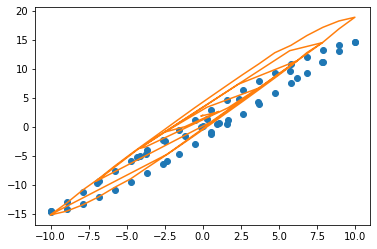

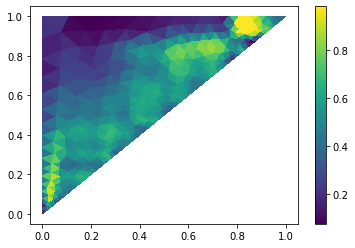

In [7]:
# prediction of hysteresis
model.hysteresis_models[0].regression()
plt.figure()
plt.plot(train_x, train_m, 'o')
plt.plot(
    train_x,
    model.hysteresis_models[0](train_x.flatten(), return_real=True).detach()
)

plot_hysterion_density(model.hysteresis_models[0])

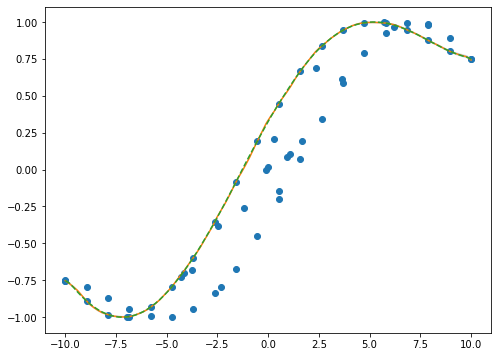

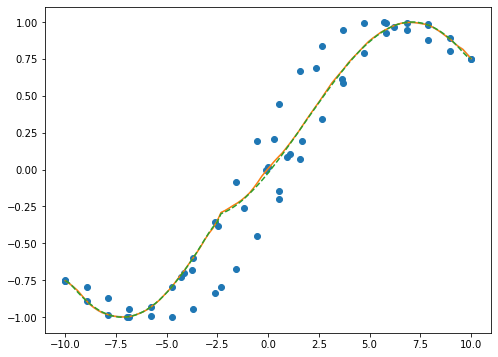

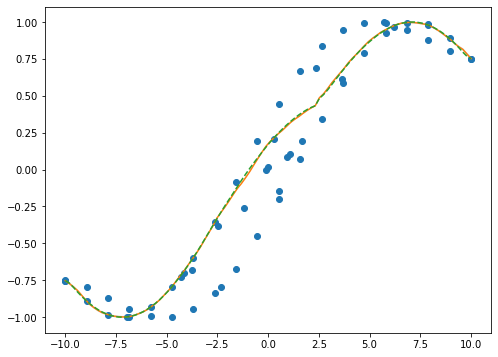

In [8]:
# predict with joint model
flds = torch.tensor([10.0, -2.5, 2.5])
for ele in flds:
    aps_model.apply_field(ele)
    aps_model.next()

    model.apply_fields(ele.reshape(1,1))
    model.next()

    test_x = torch.linspace(*H.valid_domain, 100)
    with torch.no_grad():
        post = model(test_x.double().reshape(-1, 1, 1))
        mean = post.mean
        l, u = post.confidence_region()

    m_gt = aps_model(test_x.double().reshape(-1,1,1))
    y_gt = ground_truth_function(m_gt).squeeze().detach()

    plt.figure(figsize=(8,6))
    plt.plot(train_x, train_y, 'o')
    plt.plot(test_x, mean)
    plt.fill_between(test_x, l, u, alpha=0.25)
    plt.plot(test_x, y_gt,'--')
